In [36]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [38]:
# CONFIGURATION - FIXED CLASS NAMES
DATASET_PATH = "/Users/yoges/Desktop/Deerwalk/dataset/eye dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 4

# Get class names automatically from directory structure
CLASS_NAMES = sorted([d for d in os.listdir(DATASET_PATH) 
                     if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Detected classes:", CLASS_NAMES)

Detected classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [40]:
#  DATA PREPARATION - FIXED TEST SPLIT
train_val_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = train_val_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_data = train_val_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Create proper test set (20% of total data)
test_gen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_data = test_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=1,
    subset='validation',  # This is important!
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")


Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Found 841 images belonging to 4 classes.
Training samples: 3376
Validation samples: 841
Test samples: 841


In [42]:
#  CLASS WEIGHTS FOR IMBALANCED DATA
labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights)


Class Weights: {0: 1.0156438026474128, 1: 0.9601820250284414, 2: 1.0471464019851116, 3: 0.9813953488372092}


In [44]:
# MODEL CREATION (TRANSFER LEARNING)
base_model = MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    dropout_rate=0.2
)
base_model.trainable = False  # Freeze base layers first

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 112, 112, 16)      │             432 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 112, 112, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_18 (Activation)    │ (None, 112, 112, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_pad   │ (None, 113, 113, 16)      │               0 │ activation_18[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 56, 56, 16)        │             144 │ expanded_conv_depthwise_p… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 56, 56, 16)        │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_14 (ReLU)               │ (None, 56, 56, 16)        │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │               0 │ re_lu_14[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │             136 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 8)           │               0 │ expanded_conv_squeeze_exc… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_squeeze_excite… │ (None, 1, 1, 16)          │             144 │ expanded_conv_squeeze_exc… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_9 (Add)                   │ (None, 1, 1, 16)          │               

 Total params: 1,013,492 (3.87 MB)

 Trainable params: 74,372 (290.52 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [46]:
# INITIAL TRAINING (FROZEN BASE)
# --------------------------------------------------------------
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True
)

print("\n=== Phase 1: Training with frozen base ===")
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


=== Phase 1: Training with frozen base ===
Epoch 1/10


C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 120s 979ms/step - accuracy: 0.2540 - loss: 1.4258 - val_accuracy: 0.2461 - val_loss: 1.3846
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 109s 981ms/step - accuracy: 0.2637 - loss: 1.3903 - val_accuracy: 0.2604 - val_loss: 1.3852
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.2681 - loss: 1.3921 - val_accuracy: 0.2545 - val_loss: 1.3868
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 102s 913ms/step - accuracy: 0.2501 - loss: 1.3903 - val_accuracy: 0.2461 - val_loss: 1.3842
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 102s 919ms/step - accuracy: 0.2723 - loss: 1.3850 - val_accuracy: 0.2616 - val_loss: 1.3830
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 104s 939ms/step - accuracy: 0.2738 - loss: 1.3825 - val_accuracy: 0.2913 - val_loss: 1.3830
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 100s 893ms/step - accuracy: 0.2723 - loss: 1.3836 - val_accuracy: 0.2830 - val_loss: 1.3810
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 99s 887ms/step - accuracy: 0.2803 - loss: 1.3824 -

In [48]:
#  FINE-TUNING (UNFREEZE LAST 30 LAYERS)
print("\n=== Phase 2: Fine-tuning ===")
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) - 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


=== Phase 2: Fine-tuning ===
Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.2744 - loss: 3.0585 - val_accuracy: 0.2747 - val_loss: 1.3837
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.2825 - loss: 1.7437 - val_accuracy: 0.2461 - val_loss: 1.3866
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.3172 - loss: 1.5165 - val_accuracy: 0.2461 - val_loss: 1.3935
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.3340 - loss: 1.4221 - val_accuracy: 0.2461 - val_loss: 1.4160
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.3860 - loss: 1.3346 - val_accuracy: 0.2461 - val_loss: 1.4639


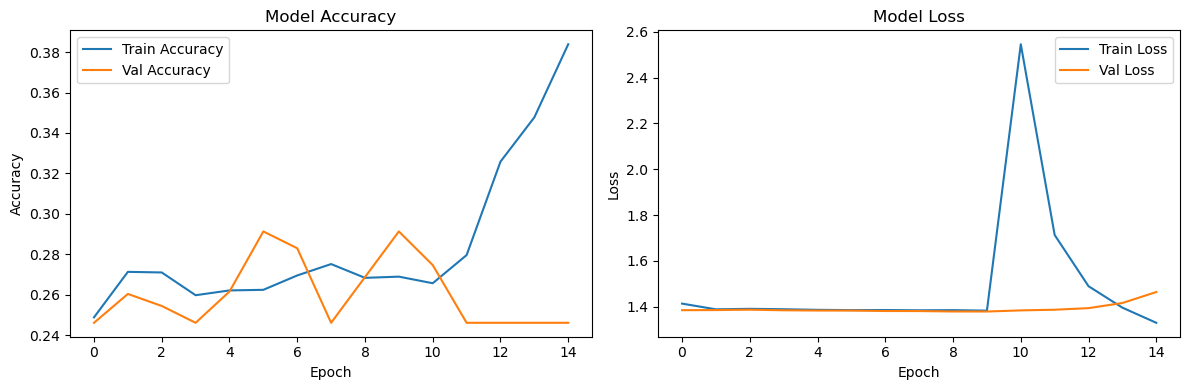

In [49]:
# COMBINE TRAINING HISTORIES AND PLOT
def combine_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

combined_history = combine_histories(history1, history2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


=== Model Evaluation ===
841/841 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.29      0.82      0.43       207
diabetic_retinopathy       0.00      0.00      0.00       219
            glaucoma       0.00      0.00      0.00       201
              normal       0.19      0.23      0.21       214

            accuracy                           0.26       841
           macro avg       0.12      0.26      0.16       841
        weighted avg       0.12      0.26      0.16       841



C:\Users\yoges\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoges\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yoges\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


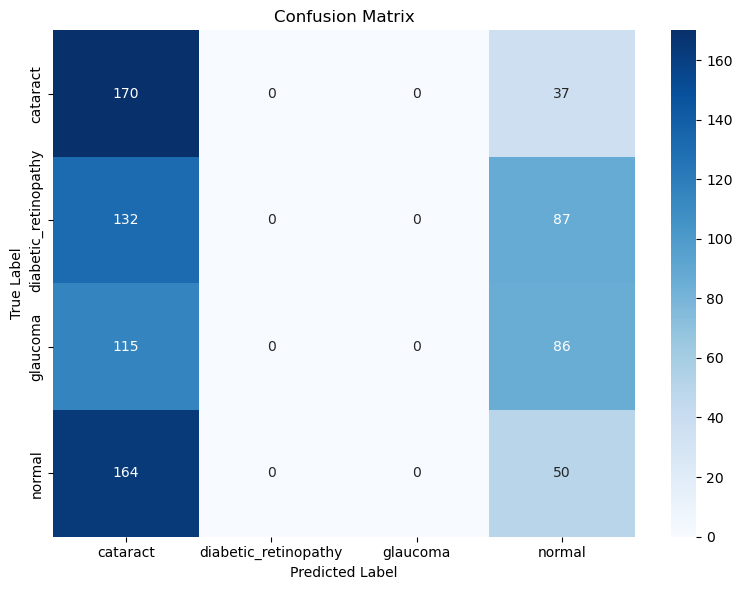

In [50]:
#  EVALUATION ON TEST SET
print("\n=== Model Evaluation ===")
# Reset test generator to ensure proper evaluation
test_data.reset()
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, 
            yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [51]:
#  IMPROVED GRAD-CAM IMPLEMENTATION
def find_conv_layer(model):
    """Find the last convolutional layer in the model"""
    for layer in reversed(model.layers):
        if 'conv' in layer.name.lower():
            return layer.name
    return model.layers[-2].name  # fallback

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize
    
    return heatmap

def display_gradcam(img_path, model, alpha=0.4):
    # Find the right convolutional layer
    last_conv_layer_name = find_conv_layer(model)
    print(f"Using layer for Grad-CAM: {last_conv_layer_name}")
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make prediction
    preds = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(preds)
    predicted_class = CLASS_NAMES[predicted_class_idx]
    confidence = np.max(preds)

    # Generate heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap to match original image
    heatmap = np.uint8(255 * heatmap)
    
    # Create visualization
    img_orig = Image.open(img_path).resize(IMG_SIZE)
    img_orig = np.array(img_orig)
    
    # Create jet colormap
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(IMG_SIZE)
    jet_heatmap = image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_orig
    superimposed_img = image.array_to_img(superimposed_img)
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img_orig)
    axes[0].set_title(f"Original: {os.path.basename(os.path.dirname(img_path))}")
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')
    
    # Superimposed
    axes[2].imshow(superimposed_img)
    axes[2].set_title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence


=== Testing Grad-CAM ===

 Testing Grad-CAM for: cataract
Using layer for Grad-CAM: conv_1_bn


C:\Users\yoges\AppData\Local\Temp\ipykernel_23152\924031609.py:26: RuntimeWarning: invalid value encountered in divide
  heatmap = heatmap / np.max(heatmap)  # Normalize
C:\Users\yoges\AppData\Local\Temp\ipykernel_23152\924031609.py:50: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


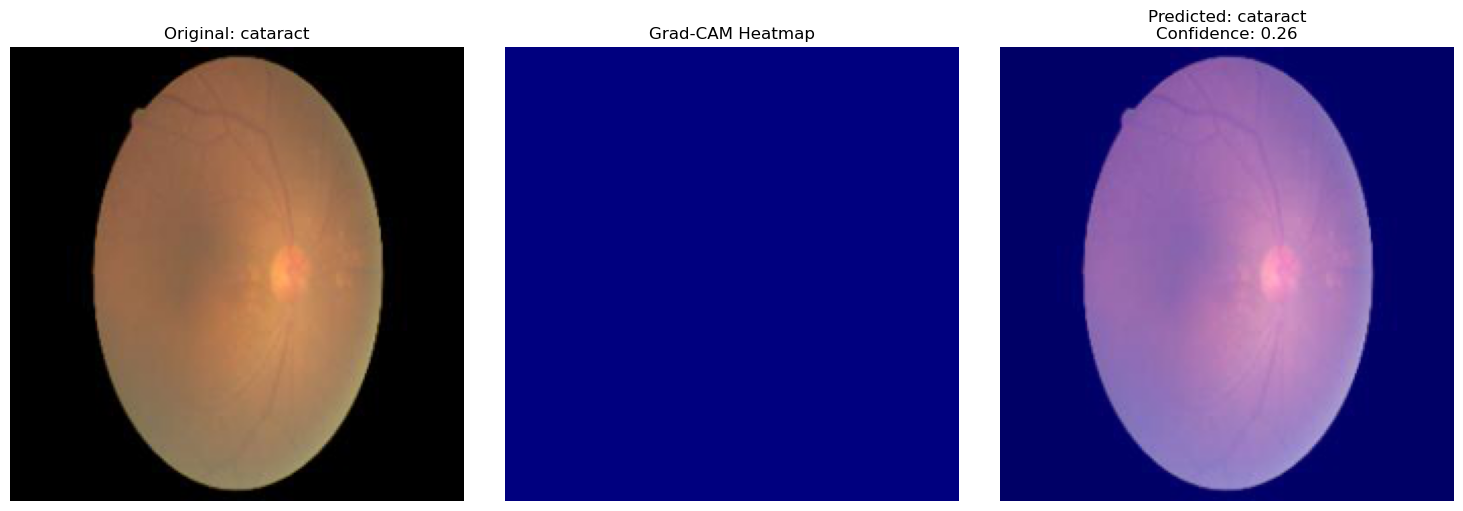


 Testing Grad-CAM for: diabetic_retinopathy
Using layer for Grad-CAM: conv_1_bn


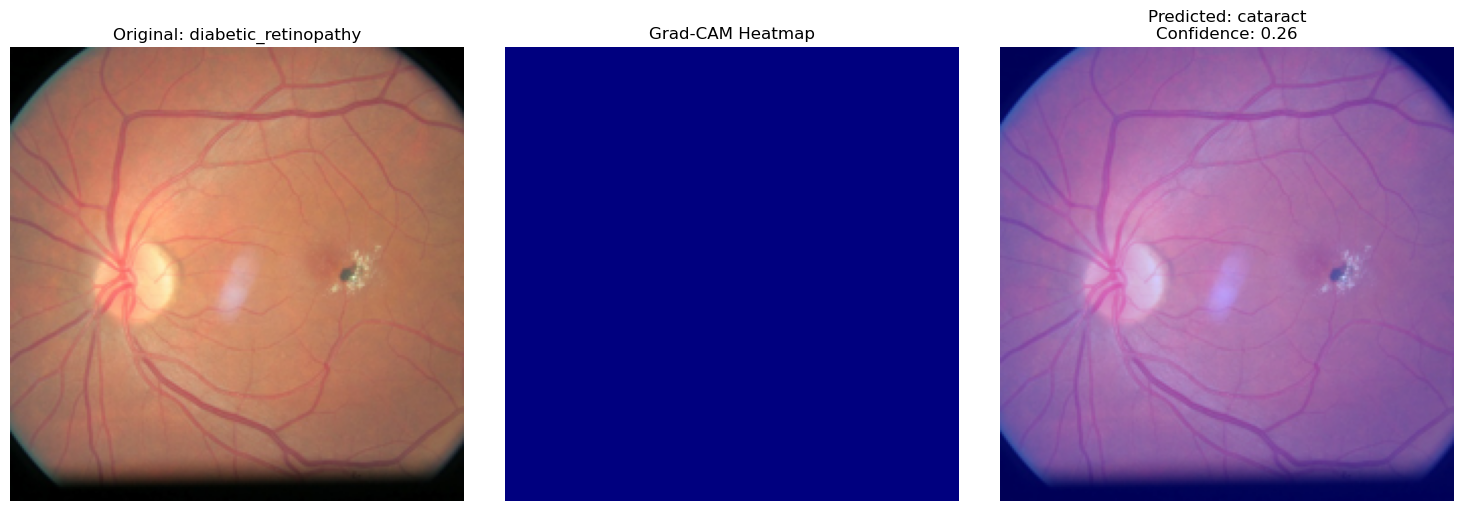


 Testing Grad-CAM for: glaucoma
Using layer for Grad-CAM: conv_1_bn


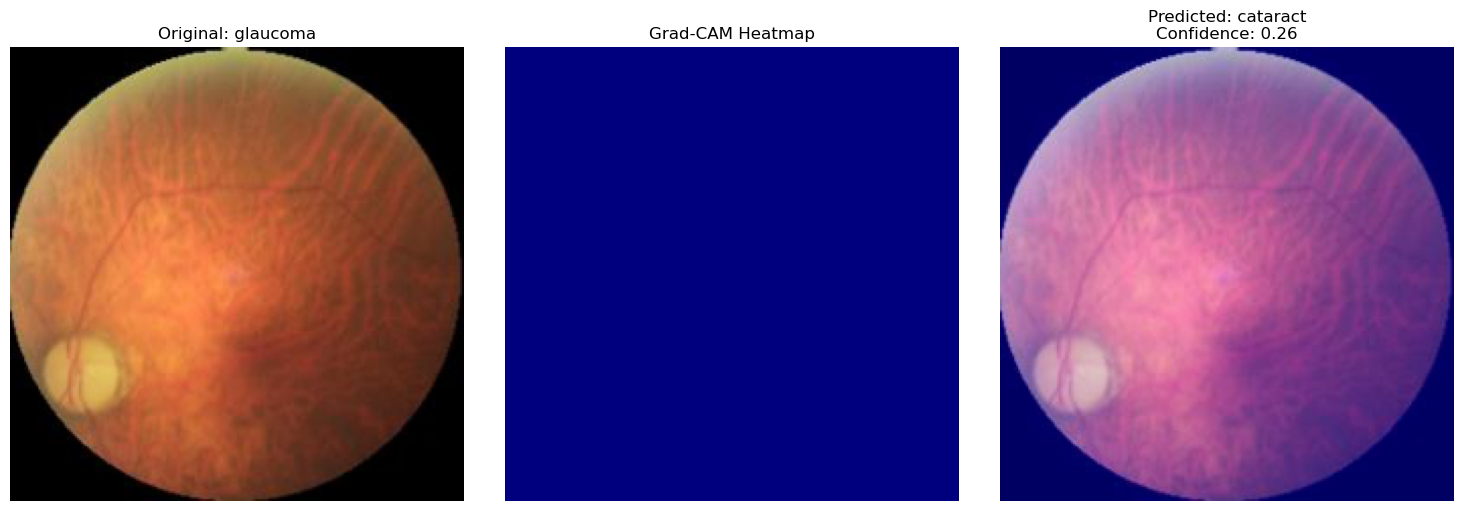


 Testing Grad-CAM for: normal
Using layer for Grad-CAM: conv_1_bn


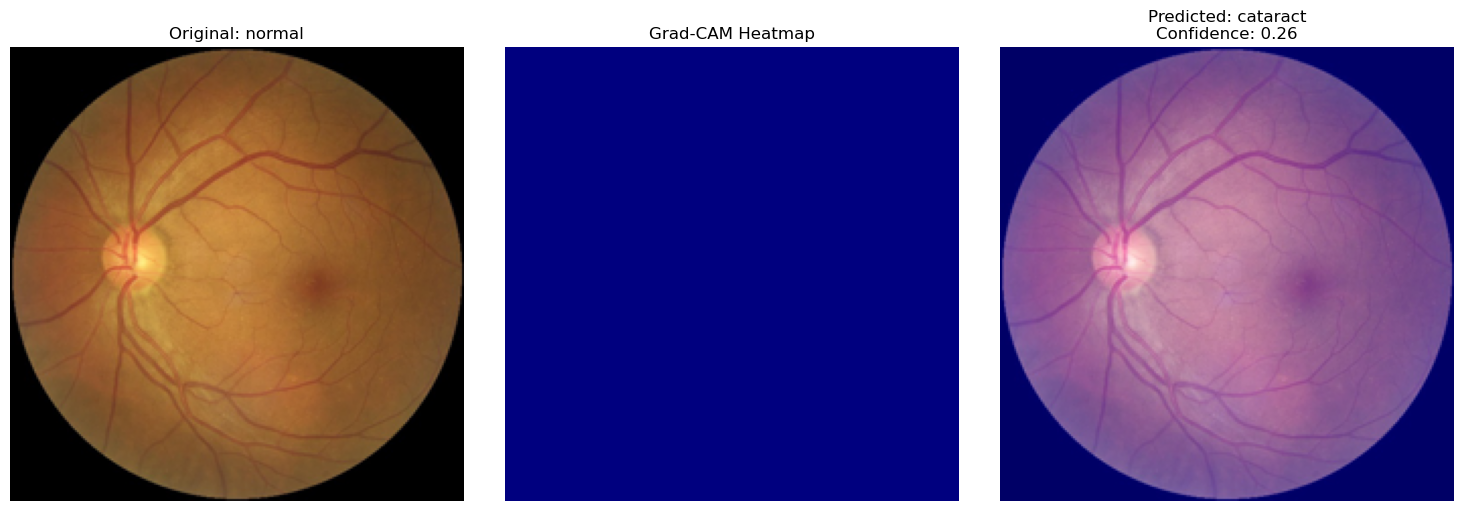


=== Final Model Performance ===
Test Accuracy: 0.2616
Test Loss: 1.3837


In [53]:
# TEST GRAD-CAM ON MULTIPLE IMAGES
print("\n=== Testing Grad-CAM ===")
# Test on one image from each class
for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_dir):
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            sample_img = random.choice(images)
            sample_path = os.path.join(class_dir, sample_img)
            print(f"\n Testing Grad-CAM for: {class_name}")
            predicted_class, confidence = display_gradcam(sample_path, model)

# Final model evaluation
print("\n=== Final Model Performance ===")
test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


In [54]:
#  GRAD-CAM IMPLEMENTATION
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model([model.inputs],
                       [model.get_layer(last_conv_layer_name).output,
                        model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

